## About Dataset

### Dataset Overview
- This dataset contains sensor data collected from various machines, with the aim of predicting machine failures in advance. It includes a variety of sensor readings as well as the recorded machine failures.

### Columns Description
- footfall: The number of people or objects passing by the machine.
- tempMode: The temperature mode or setting of the machine.
- AQ: Air quality index near the machine.
- USS: Ultrasonic sensor data, indicating proximity measurements.
- CS: Current sensor readings, indicating the electrical current usage of the machine.
- VOC: Volatile organic compounds level detected near the machine.
- RP: Rotational position or RPM (revolutions per minute) of the machine parts.
- IP: Input pressure to the machine.
- Temperature: The operating temperature of the machine.
- fail: Binary indicator of machine failure (1 for failure, 0 for no failure).

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from scipy import stats

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [5]:
df = pd.read_csv('data/data.csv')

# Let's get basic information about the dataset
print("\nBasic Information:")
print(df.info())

print("\nFirst few rows:")
print(df.head())

print("\nBasic statistics:")
print(df.describe())

print("\nMissing values:")
print(df.isnull().sum())

# Count of failures vs non-failures
print("\nFailure distribution:")
print(df['fail'].value_counts())
print("\nFailure percentage:")
print(df['fail'].value_counts(normalize=True) * 100)


Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   footfall     944 non-null    int64
 1   tempMode     944 non-null    int64
 2   AQ           944 non-null    int64
 3   USS          944 non-null    int64
 4   CS           944 non-null    int64
 5   VOC          944 non-null    int64
 6   RP           944 non-null    int64
 7   IP           944 non-null    int64
 8   Temperature  944 non-null    int64
 9   fail         944 non-null    int64
dtypes: int64(10)
memory usage: 73.9 KB
None

First few rows:
   footfall  tempMode  AQ  USS  CS  VOC  RP  IP  Temperature  fail
0         0         7   7    1   6    6  36   3            1     1
1       190         1   3    3   5    1  20   4            1     0
2        31         7   2    2   6    1  24   6            1     0
3        83         4   3    4   5    1  28   6            1     

Key Initial Insights:
1. We have 944 records with no missing values
2. All variables are stored as integers
3. Class distribution shows:
   - 58.37% are non-failures (551 cases)
   - 41.63% are failures (393 cases)
   - This is fairly balanced, which is good for modeling
4. Some interesting observations from the statistics:
   - Footfall has a large range (0-7300) with high standard deviation
   - Most variables (AQ, USS, CS, VOC) are on a scale of 1-7
   - Temperature ranges from 1 to 24
   - RP (Rotational Position) has notably different scale (19-91)

## Visualizations to better understand the patterns

1. Distribution plots for each variable, colored by failure status
2. A correlation matrix to see relationships between variables
3. Box plots to see how each variable differs between failure and non-failure cases

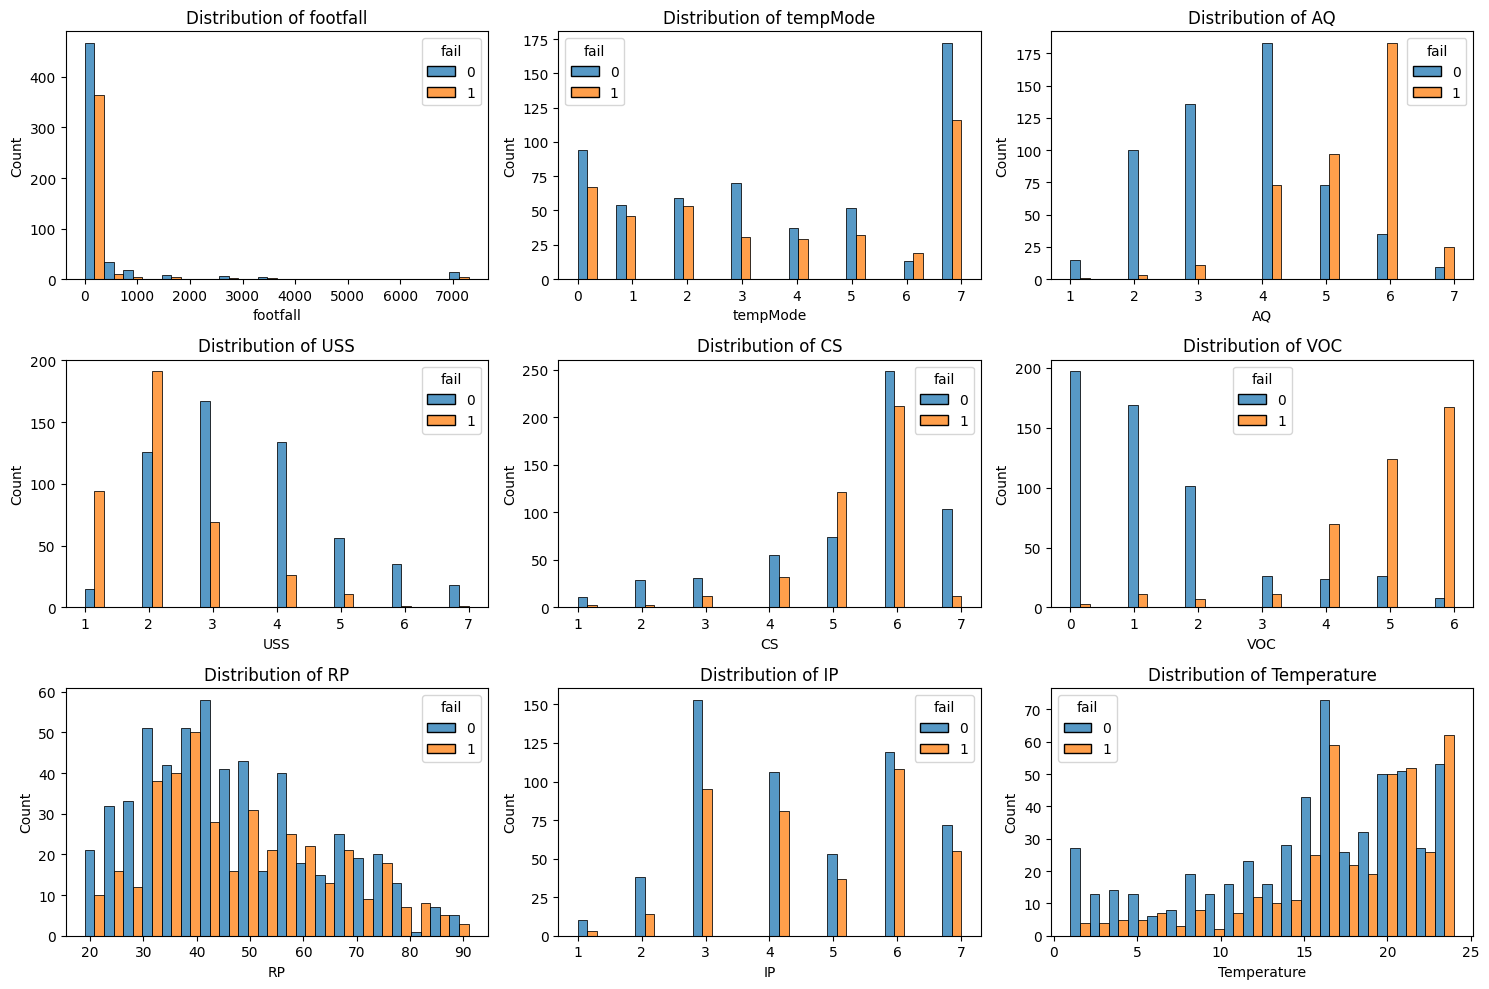

In [6]:
plt.figure(figsize=(15, 10))

# Plot histograms for each numerical variable colored by failure
for i, column in enumerate(['footfall', 'tempMode', 'AQ', 'USS', 'CS', 'VOC', 'RP', 'IP', 'Temperature'], start=1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=column, hue='fail', multiple="dodge", bins=20)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    
plt.tight_layout()
plt.show()

1. Most Significant Predictors of Failure:
- VOC (Volatile Organic Compounds) shows the strongest correlation with failures (0.8 correlation)
- AQ (Air Quality) also has a moderate positive correlation (0.58) with failures
- USS (Ultrasonic Sensor) has a moderate negative correlation (-0.47) with failures

2. Distribution Patterns:
- Footfall: Highly skewed right, with most values concentrated near 0
- VOC: Clear separation between failure/non-failure cases:
  * Low VOC levels (0-2) associate with non-failures
  * High VOC levels (4-6) associate with failures
- AQ: Similar pattern to VOC, with higher values associated with failures

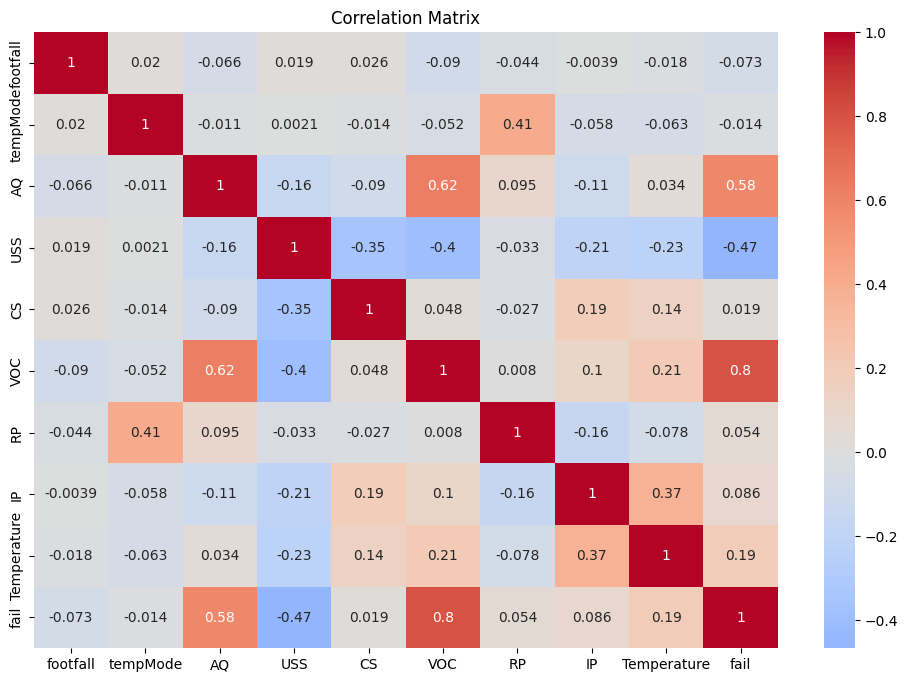

In [7]:
# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

3. Notable Correlations Between Features:
- VOC and AQ are moderately correlated (0.62)
- tempMode and RP show some correlation (0.41)
- IP and Temperature show weak positive correlation (0.37)

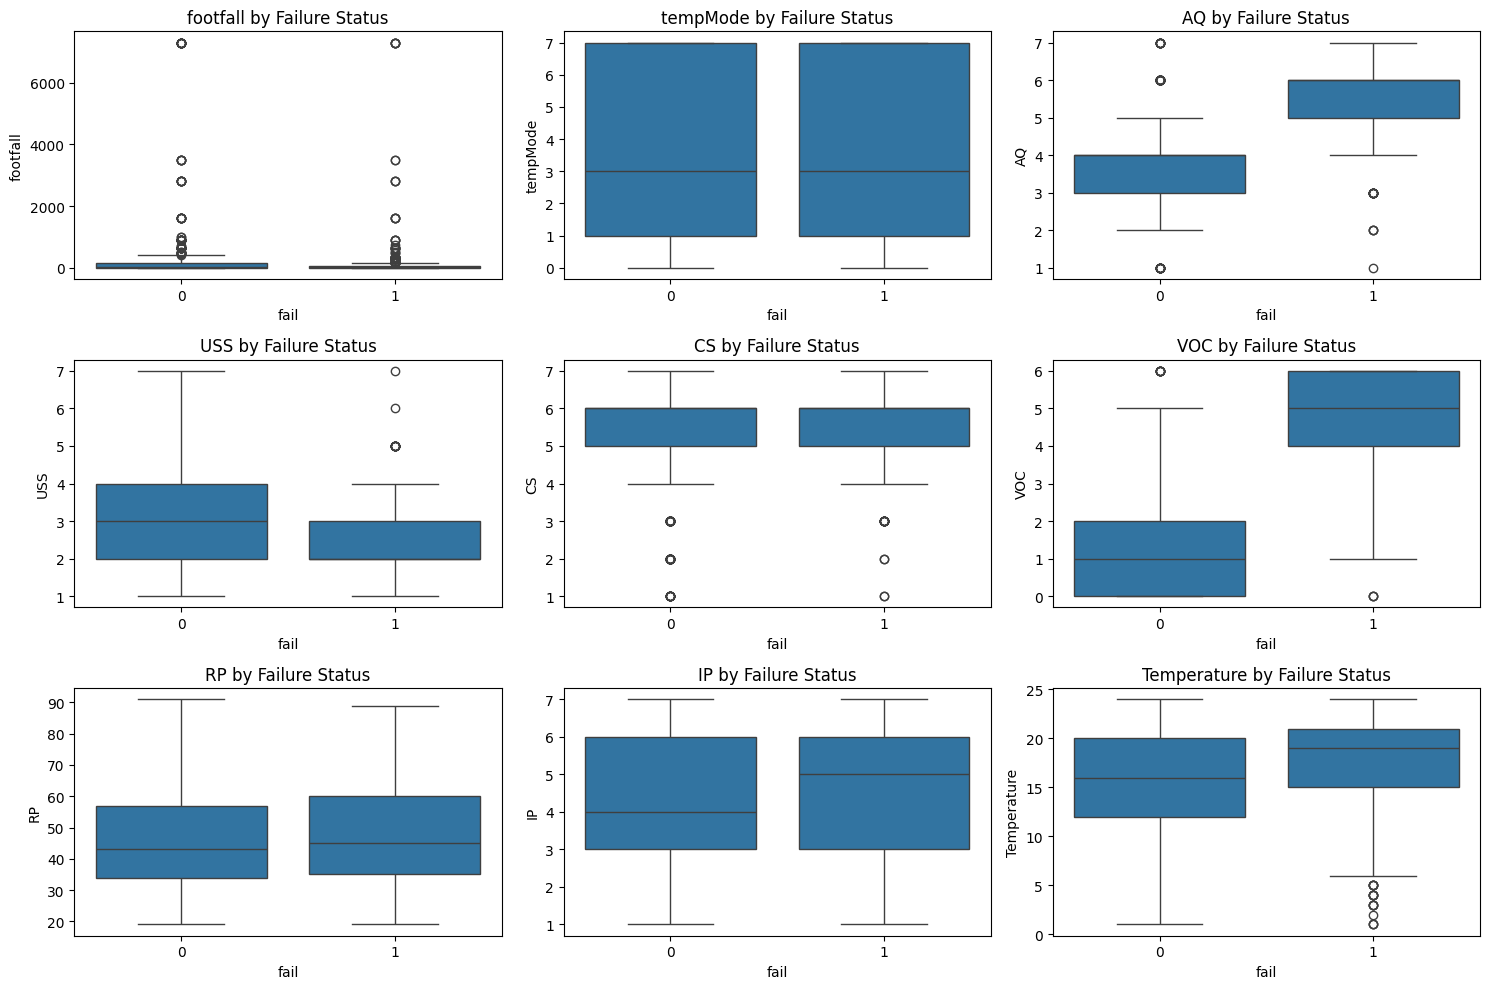

In [8]:
# Box plots for each variable by failure status
plt.figure(figsize=(15, 10))
for i, column in enumerate(['footfall', 'tempMode', 'AQ', 'USS', 'CS', 'VOC', 'RP', 'IP', 'Temperature'], start=1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, x='fail', y=column)
    plt.title(f'{column} by Failure Status')

plt.tight_layout()
plt.show()

4. Box Plot Insights:
- VOC: Shows the clearest separation between failure/non-failure cases
- AQ: Higher values tend to indicate failures
- USS: Slightly lower values in failure cases
- Temperature: Slightly higher in failure cases
- Other variables show less clear separation

## Failure rates by VOC and AQ levels

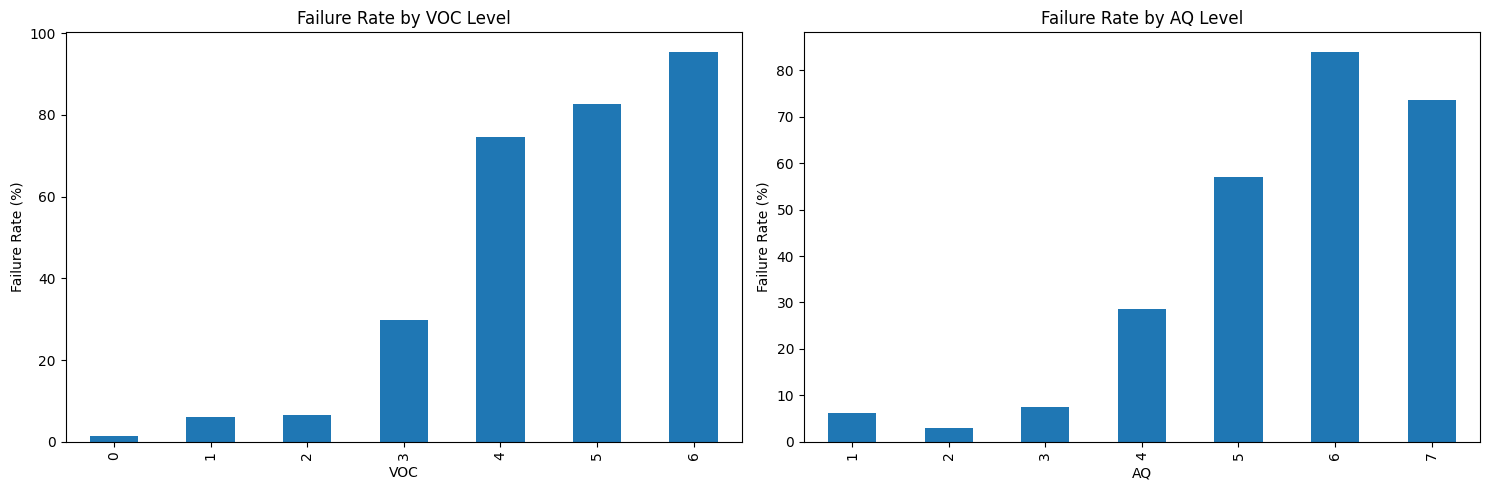

In [9]:
plt.figure(figsize=(15, 5))

# VOC failure rate
plt.subplot(1, 2, 1)
failure_rate_voc = df.groupby('VOC')['fail'].mean() * 100
failure_rate_voc.plot(kind='bar')
plt.title('Failure Rate by VOC Level')
plt.ylabel('Failure Rate (%)')

# AQ failure rate
plt.subplot(1, 2, 2)
failure_rate_aq = df.groupby('AQ')['fail'].mean() * 100
failure_rate_aq.plot(kind='bar')
plt.title('Failure Rate by AQ Level')
plt.ylabel('Failure Rate (%)')

plt.tight_layout()
plt.show()

1. VOC Level and Failure Rate:
- There's a clear progressive increase in failure rate as VOC levels increase
- VOC levels 0-2: Very low failure rate (<10%)
- VOC levels 3-4: Moderate failure rate (25-75%)
- VOC levels 5-6: Very high failure rate (>80-95%)
- This suggests VOC could be a critical early warning indicator

2. AQ Level and Failure Rate:
- Similar progressive pattern but with more distinct thresholds
- AQ levels 1-3: Low failure rate (<10%)
- AQ level 4: Moderate failure rate (~30%)
- AQ levels 5-7: High failure rate (>55%)
- Peaks at AQ=6 with about 85% failure rate



## Interaction between VOC and AQ

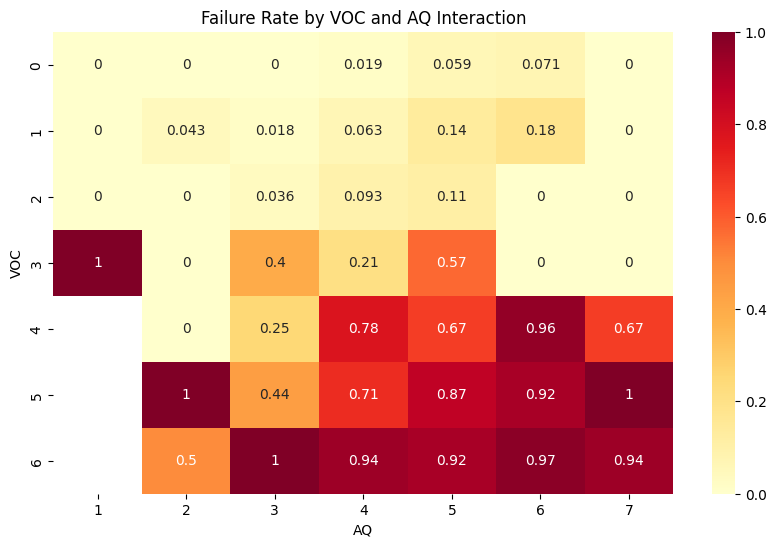

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.pivot_table(index='VOC', columns='AQ', values='fail', aggfunc='mean'),
            annot=True, cmap='YlOrRd')
plt.title('Failure Rate by VOC and AQ Interaction')
plt.show()

3. VOC and AQ Interaction (Heatmap):
- Highest failure rates (>90%) occur when:
  * VOC ≥ 5 AND AQ ≥ 4
  * VOC = 6 AND AQ ≥ 3
- Low VOC (0-2) generally shows low failure rates regardless of AQ
- There's a clear "danger zone" in the bottom-right of the heatmap

Practical Implications:
1. Monitoring Thresholds:
   - Critical VOC threshold appears to be around 4
   - Critical AQ threshold appears to be around 5
   - When either exceeds these levels, preventive maintenance should be considered

2. Early Warning System Could:
   - Trigger Yellow Alert: When VOC > 3 OR AQ > 4
   - Trigger Red Alert: When VOC > 4 OR AQ > 5
   - Trigger Critical Alert: When both VOC ≥ 5 AND AQ ≥ 4


## Hypothesis testing to statistically validate our observations

1. Mann-Whitney U Test:
- To compare if there's a statistically significant difference in VOC and AQ values between failure and non-failure cases
- We use this non-parametric test since our distributions don't appear normal

In [11]:
# Mann-Whitney U Test for VOC and AQ
print("Mann-Whitney U Test Results:")
print("\nVOC by Failure Status:")
stat_voc, p_voc = stats.mannwhitneyu(df[df['fail']==0]['VOC'], 
                                    df[df['fail']==1]['VOC'],
                                    alternative='two-sided')
print(f"p-value: {p_voc}")

print("\nAQ by Failure Status:")
stat_aq, p_aq = stats.mannwhitneyu(df[df['fail']==0]['AQ'], 
                                  df[df['fail']==1]['AQ'],
                                  alternative='two-sided')
print(f"p-value: {p_aq}")

Mann-Whitney U Test Results:

VOC by Failure Status:
p-value: 1.9556808624888484e-122

AQ by Failure Status:
p-value: 1.9991236844866447e-75


 **Mann-Whitney U Test Results**:
- VOC: p ≈ 1.96e-122 (much smaller than 0.05)
- AQ: p ≈ 2.00e-75 (much smaller than 0.05)
These incredibly small p-values indicate that:
- There is a statistically significant difference in VOC values between failing and non-failing machines
- There is a statistically significant difference in AQ values between failing and non-failing machines
- The probability that these differences occurred by chance is essentially zero


2. Chi-Square Test of Independence:
- To test if the relationship between discretized VOC/AQ levels and failures is statistically significant
- This will help confirm if the patterns we see in the failure rates are not due to chance

In [12]:
# Chi-Square Test of Independence
# VOC
contingency_voc = pd.crosstab(df['VOC'], df['fail'])
print("\nChi-Square Test for VOC and Failure:")
chi2_voc, p_chi2_voc = stats.chi2_contingency(contingency_voc)[:2]
print(f"p-value: {p_chi2_voc}")

# AQ
contingency_aq = pd.crosstab(df['AQ'], df['fail'])
print("\nChi-Square Test for AQ and Failure:")
chi2_aq, p_chi2_aq = stats.chi2_contingency(contingency_aq)[:2]
print(f"p-value: {p_chi2_aq}")


Chi-Square Test for VOC and Failure:
p-value: 2.231251441194504e-134

Chi-Square Test for AQ and Failure:
p-value: 5.83593557051127e-73



**Chi-Square Test Results**:
- VOC: p ≈ 2.23e-134
- AQ: p ≈ 5.84e-73
These results confirm that:
- There is a strong statistical association between VOC levels and machine failures
- There is a strong statistical association between AQ levels and machine failures
- The relationships we observed in our visualizations are statistically valid

Practical Implications:
1. We can confidently use both VOC and AQ as predictors for machine failure
2. VOC appears to be the stronger predictor (smaller p-value in both tests)
3. These results support implementing a monitoring system based on these variables

Would you like to:
1. Run similar tests for other variables to identify secondary predictors?
2. Create threshold-based rules using these variables?
3. Begin developing a predictive model using these insights?

Let me know which direction you'd like to explore next!

## Variance Inflation Factor (VIF) to formally assess multicollinearity

In [13]:
# Calculate VIF for each feature
def calculate_vif(df, features):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i)
                       for i in range(len(features))]
    return vif_data.sort_values('VIF', ascending=False)

# Select features (excluding the target 'fail')
features = ['footfall', 'tempMode', 'AQ', 'USS', 'CS', 'VOC', 'RP', 'IP', 'Temperature']

# Calculate VIF values
vif_df = calculate_vif(df, features)
print("\nVariance Inflation Factors:")
print(vif_df)


Variance Inflation Factors:
       Feature        VIF
2           AQ  14.806319
4           CS  13.932703
7           IP  10.245331
6           RP  10.218435
8  Temperature   9.821603
3          USS   5.150000
5          VOC   5.129437
1     tempMode   3.545839
0     footfall   1.090362


The VIF results show that we do have some significant multicollinearity issues in our dataset:

Severe Multicollinearity (VIF > 10):
1. AQ: 14.81
2. CS: 13.93
3. IP: 10.25
4. RP: 10.22

Moderate Multicollinearity (5 < VIF < 10):
1. Temperature: 9.82
2. USS: 5.15
3. VOC: 5.13

Lower Multicollinearity (VIF < 5):
1. tempMode: 3.55
2. footfall: 1.09

## PCA to handle multicollinearity

Explained variance ratio by component:
PC1: 0.227 (0.227 cumulative)
PC2: 0.180 (0.407 cumulative)
PC3: 0.149 (0.555 cumulative)
PC4: 0.111 (0.666 cumulative)
PC5: 0.105 (0.771 cumulative)
PC6: 0.070 (0.841 cumulative)
PC7: 0.063 (0.904 cumulative)
PC8: 0.061 (0.965 cumulative)
PC9: 0.035 (1.000 cumulative)


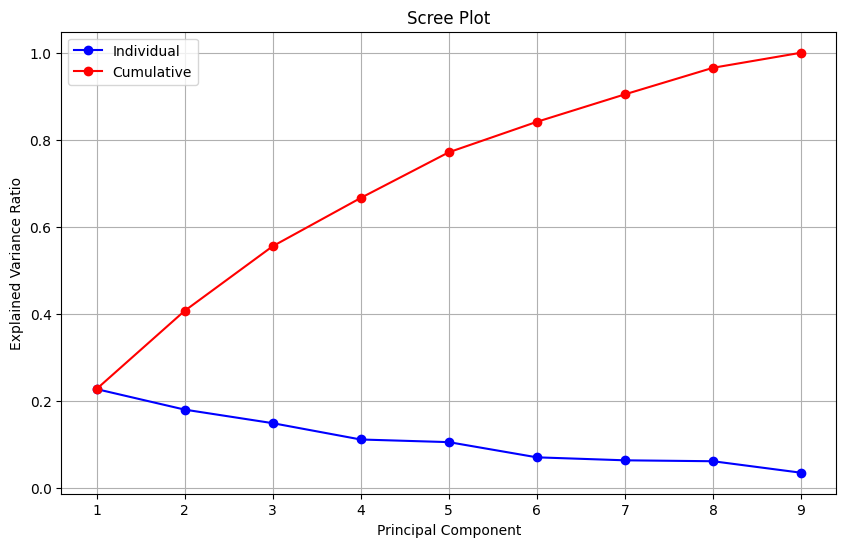


Component loadings:
                  PC1       PC2       PC3       PC4       PC5       PC6  \
footfall    -0.076692 -0.126169  0.090956  0.839975 -0.505699  0.036031   
tempMode    -0.106729  0.329107  0.597514 -0.089957 -0.225447 -0.363144   
AQ           0.344371  0.511279 -0.302500  0.104881 -0.102453 -0.033272   
USS         -0.495786 -0.003419 -0.235322 -0.198708 -0.281908  0.090760   
CS           0.275542 -0.258018  0.380981  0.270691  0.533856  0.128467   
VOC          0.529131  0.339085 -0.204385  0.062435 -0.067377 -0.121784   
RP          -0.073562  0.456402  0.509472 -0.101247 -0.051799  0.334404   
IP           0.322391 -0.404110  0.168292 -0.264360 -0.336419 -0.549492   
Temperature  0.391257 -0.247371  0.114099 -0.280278 -0.445051  0.642169   

                  PC7       PC8       PC9  
footfall    -0.046783  0.064896  0.030644  
tempMode     0.352225 -0.456444 -0.008875  
AQ           0.306560  0.196976 -0.610831  
USS          0.602823  0.371638  0.264770  
CS      

In [14]:
# First, let's prepare our data
# Select features (excluding target)
features = ['footfall', 'tempMode', 'AQ', 'USS', 'CS', 'VOC', 'RP', 'IP', 'Temperature']
X = df[features]
y = df['fail']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Print the explained variance ratio for each component
print("Explained variance ratio by component:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio:.3f} ({cumulative_variance_ratio[i]:.3f} cumulative)")

# Create a scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-')
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, 'ro-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend(['Individual', 'Cumulative'])
plt.grid(True)
plt.show()

# Let's also look at the component loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(features))],
    index=features
)
print("\nComponent loadings:")
print(loadings)

Let me analyze these PCA results for you:

1. Explained Variance Analysis:
- First 3 PCs explain 55.5% of variance
- First 5 PCs explain 77.1% of variance
- First 7 PCs explain 90.4% of variance

2. Scree Plot Interpretation:
- There's no clear "elbow" point, but there are a few potential cutoff points:
  * After PC3 (55.5% variance explained)
  * After PC5 (77.1% variance explained)
  * After PC7 (90.4% variance explained)
- The decline in individual variance explained becomes more gradual after PC5


PC1 (22.7% variance):
- Strongest positive loadings: VOC (0.529), Temperature (0.391), AQ (0.344)
- Strongest negative loading: USS (-0.496)
- This component seems to represent environmental conditions

PC2 (18.0% variance):
- Strongest positive loadings: AQ (0.511), RP (0.456), tempMode (0.329)
- Strongest negative loading: IP (-0.404)
- Represents operational settings and air quality

PC3 (14.9% variance):
- Strongest positive loadings: tempMode (0.598), RP (0.509)
- Strongest negative loading: AQ (-0.303)
- Captures temperature and rotational characteristics

PC4 (11.1% variance):
- Dominated by footfall (0.840)
- Represents usage intensity

PC5 (10.5% variance):
- Strongest positive loading: CS (0.534)
- Strongest negative loadings: footfall (-0.506), Temperature (-0.445)
- Represents electrical performance vs usage

**Use 5 PCs because**:
   - Explains 77.1% of variance
   - Each component has clear physical interpretation
   - Key failure indicators (VOC, AQ) are well-represented in early components
   - Meaningful reduction from 9 to 5 dimensions




Correlations with failure:
PC1: 0.675
PC2: 0.403
PC3: -0.151
PC4: 0.067
PC5: -0.049


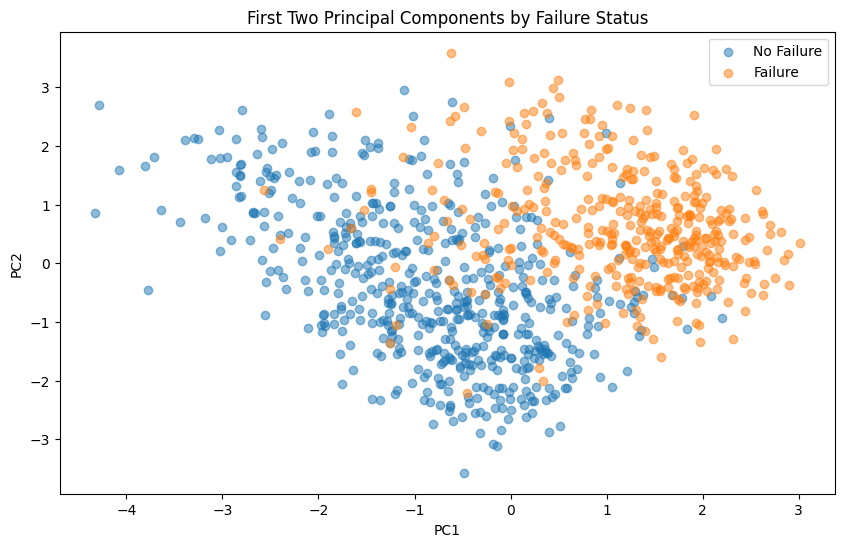

In [15]:
# Create 5-component PCA
pca_5 = PCA(n_components=5)
X_pca_5 = pca_5.fit_transform(X_scaled)

# Create dataframe with PCs and failure
pca_df = pd.DataFrame(X_pca_5, columns=[f'PC{i+1}' for i in range(5)])
pca_df['fail'] = y

# Calculate correlations with failure
correlations = [pca_df[f'PC{i+1}'].corr(pca_df['fail']) for i in range(5)]
print("\nCorrelations with failure:")
for i, corr in enumerate(correlations):
    print(f"PC{i+1}: {corr:.3f}")

# Visualize first two PCs by failure status
plt.figure(figsize=(10, 6))
plt.scatter(pca_df[pca_df['fail']==0]['PC1'], 
           pca_df[pca_df['fail']==0]['PC2'], 
           alpha=0.5, label='No Failure')
plt.scatter(pca_df[pca_df['fail']==1]['PC1'], 
           pca_df[pca_df['fail']==1]['PC2'], 
           alpha=0.5, label='Failure')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('First Two Principal Components by Failure Status')
plt.legend()
plt.show()

1. Correlation Analysis:
- PC1 has a strong correlation with failure (0.675)
- PC2 has a moderate correlation with failure (0.403)
- PC3-PC5 have weak correlations (all < 0.2)
- This suggests most of the failure-relevant information is captured in the first two components

2. Scatter Plot Analysis:
- Clear separation pattern between failure/no-failure cases
- Failures (orange) tend to cluster towards higher PC1 values (right side)
- Non-failures (blue) tend to cluster towards lower PC1 values (left side)
- Some overlap in the middle indicates the relationship isn't perfectly linear
- PC2 provides additional separation, with failures showing more spread in the positive direction

3. Recommendations:
a) For Dimensionality Reduction:
   - Could potentially use just PC1 and PC2 for a simplified model (explains 40.7% of variance)
   - These two components capture the strongest failure relationships
   - This would reduce our features from 9 to 2 while maintaining key predictive power

b) For Machine Learning:
   - Use PC1 and PC2 as primary features
   - Consider including PC3 for additional nuance
   - Can drop PC4 and PC5 as they show minimal correlation with failures